# Project 3
Griffith Stites and Alex Hindelang

## Assumptions
* Ignoring temperature changes for the fluid and how this effects density. Just choosing based off of the ideal temperature from the engineeringtoolbox chart
* That the force of the penguin exerted on the fluid does not change based on fluid density.

## To Do
* Calculate Emperor penguin Coefficient of drag
* Find Emperor penguin frontal area
* Add QMRI details
* Add penguin speed (In results) in kph as well as m/s
* Add graph label with penguin type and fluid density (Could just be print out)
* Find speed penguin flaps wings

# Question

In [47]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# import matlab like plotting functions
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
import math

# Model

In [48]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
km = UNITS.kilometer
hr = UNITS.hour
s = UNITS.second
N = UNITS.newton

<Unit('newton')>

rho_water

C_d = Coeffient of drag of the penguin

frontal_area = The frontal area of the penguin

velocity_init = starting velocity of the penguin

pool_length = length of the pool. An olympic swimming pool is 50 m

C_d and frontal_area are currently for the gentoo penguin

In [49]:
rho_water = 1000 * kg/m**3
rho_sea_water = 1025 * kg/m**3
rho_syrup = 1370 * kg/m**3
rho_propyl_alcohol = 800 * kg/m**3
rho_air = 1.2 * kg/m**3

gentoo_mass =  5.8967 * kg
gentoo_max_speed = 10 * m / s
gentoo_flap_rate = 4 #Number of times per second the penguin flaps its wings

params = Params(rho = rho_sea_water,
                C_d = 0.07,
                frontal_area = 0.02 * m**2,
                velocity_init = 0 * m / s,
                pool_length = 50 * m,
                p_mass = gentoo_mass,
                p_max_speed = gentoo_max_speed,
                p_flap_speed = 1/gentoo_flap_rate
)

,values
rho,1025.0 kilogram / meter ** 3
C_d,0.07
frontal_area,0.02 meter ** 2
velocity_init,0.0 meter / second
pool_length,50 meter
p_mass,5.8967 kilogram
p_max_speed,10.0 meter / second
p_flap_speed,0.25


In [50]:
def make_system(params):
    """Make a system object.
    
    params: Params object with
    
    returns: System object"""
    unpack(params)
    init = State(x=0 * m, v=velocity_init)
    t_end = 100 * s
    
    return System(params, init=init, t_end=t_end)

In [51]:
system = make_system(params)

,values
rho,1025.0 kilogram / meter ** 3
C_d,0.07
frontal_area,0.02 meter ** 2
velocity_init,0.0 meter / second
pool_length,50 meter
p_mass,5.8967 kilogram
p_max_speed,10.0 meter / second
p_flap_speed,0.25
init,x 0 meter v 0.0 meter / secon...
t_end,100 second


In [52]:
def force_drag(V, system):
    """Computes drag force in the opposite direction of 'v'.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: scalar drag force
    """
    unpack(system)
    f_drag_mag = -rho * V**2 * C_d * frontal_area / 2
    return f_drag_mag

Average Force of the penguin can be determined by finding the maximum speed of a penguin in salt water. Assuming that the drag force of the salt water is equal to the force of the penguin swimming and by knowing the drag coefficient of the penguin we can determine the swimming force of the penguin.

Force is sinusoidal due to the flapping of the penguins fins. Center the sin wave around the average force.

time determines place in sin wave

In [65]:
def force_penguin(t, system):
    """Computes the force the penguin exerts on the fluid.
    
    t: time
    system: System object
    
    returns: Scalar penguin force"""
    params_penguin = params
    params_penguin.rho = rho_sea_water
    system_penguin = make_system(params_penguin)
    f_penguin_avg = - force_drag(system.p_max_speed, system_penguin)
    #Checks to see where the penguin is in its motion
    p_flap = math.sin((1/system.p_flap_speed) * 2 * pi * t)
    #Checks to see if the penguin is exerting force on the water or if it between strokes
    if (p_flap > 0):
        f_penguin = p_flap * 2 * f_penguin_avg
    else: 
        f_penguin = 0
    return f_penguin

In [55]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State ()
    t: time
    system: System object with
    
    returns: derivatives of y and v
    """
    x, v = state
    unpack(system)    

    f_drag = force_drag(v, system)
    f_penguin = force_penguin(t, system)
    #print('time = ', t)
    #print('f_drag = ', f_drag)
    #print('f_penguin = ', f_penguin)
    
    f_total = f_penguin + f_drag
    
    dydt = v
    dvdt = f_total / p_mass #acceleration
    
    return dydt, dvdt

In [56]:
def event_func(state, t, system):
    """Return the ditance of the penguin in the pool.
    
    state: state object with the position and velocity of the penguin
    t: int representing the time the model is at
    system: system object with the model params
    """
    x, v = state
    return x - system.pool_length

In [57]:
def analyze_results(results, system, title):
    """Plot the results of a penguin model and provide summary statements.
    
    results: Dataframe with the results of the model
    system: System object for the model
    title: String with title of the model"""
    
    plot_info(system)
    
    #Changes the size of the figure
    figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
    #Changes the font of the figure
    font = {'family' : 'DejaVu Sans',
            'weight' : 'normal',
            'size'   : 30}
    matplotlib.rc('font', **font)

    #Creates the position vs time plot
    plt.subplot(1, 2, 1)
    plt.plot(results.index, results.x, color='lightgreen', linewidth=7.0)
    plt.title(title + ': Position vs Time', fontsize = 40)
    plt.xlabel('Time (Seconds)', fontsize = 20)
    plt.ylabel('Position (Meters)', fontsize = 20)
    
    #Creates the velocity vs time plot
    plt.subplot(1, 2, 2)
    plt.plot(results.index, results.v, color='lightblue', linewidth=7.0)
    plt.title(title + ': Velocity vs Time', fontsize = 40)
    plt.xlabel('Time (Seconds)', fontsize = 20)
    plt.ylabel('Velocity (m/s)', fontsize = 20)
    
    plt.show()
    
    calc_total_time(results)
    calc_max_speed(results)
    calc_avg_speed(results)

In [58]:
def plot_info(system):
    """Print the penguin mass, flap rate, and fluid density for the plot.
    
    system: System object
    """
    p_mass_str = str(system.p_mass)
    print('\x1b[1;31m'+'Penguin mass: '+'\x1b[0m', 
          '\x1b[1;31m'+ p_mass_str +'\x1b[0m')
    p_flap_str = str(1/system.p_flap_speed)
    print('\x1b[1;31m'+'Penguin flap rate: '+'\x1b[0m', 
          '\x1b[1;31m'+ p_flap_str +'\x1b[0m',
          '\x1b[1;31m'+ 'times / second'+'\x1b[0m')
    rho_str = str(system.rho)
    print('\x1b[1;31m'+'Fluid density: '+'\x1b[0m', 
          '\x1b[1;31m'+ rho_str +'\x1b[0m')

In [59]:
def calc_total_time(results):
    """Calculate and print the total time.
    
    results: DataFrame
    """
    time = round(results.last_valid_index(), 2)
    time_str = str(time)  
    print('\x1b[1;31m'+'The total time it took the penguin to get to the end of the pool was'+'\x1b[0m', 
          '\x1b[1;31m'+ time_str +'\x1b[0m', '\x1b[1;31m'+'seconds.'+'\x1b[0m')

In [60]:
def calc_max_speed(results):
    """Calculate and print the max speed of the penguin in the fluid.
    
    results: DataFrame
    """
    max_speed = results.v.max()
    max_speed_str = str(round(max_speed, 2))
    
    max_speed_kph = round ((max_speed * 3.6), 2)
    max_speed_kph_str = str(max_speed_kph)
    
    print('\x1b[1;31m'+'The max speed of the penguin was'+'\x1b[0m', 
          '\x1b[1;31m'+ max_speed_str +'\x1b[0m', 
          '\x1b[1;31m'+'m/s or'+'\x1b[0m',
          '\x1b[1;31m'+ max_speed_kph_str +'\x1b[0m',
          '\x1b[1;31m'+'kph.'+'\x1b[0m')

In [61]:
def calc_avg_speed(results):
    """Calculate and print the average speed of the penguin in the fluid.
    
    results: DataFrame
    """
    avg_speed = results.v.mean()
    avg_speed_str = str(round(avg_speed, 2))
    
    avg_speed_kph = round ((avg_speed * 3.6), 2)
    avg_speed_kph_str = str(avg_speed_kph)
    
    print('\x1b[1;31m'+'The average speed of the penguin was'+'\x1b[0m', 
          '\x1b[1;31m'+ avg_speed_str +'\x1b[0m', 
          '\x1b[1;31m'+'m/s or'+'\x1b[0m',
          '\x1b[1;31m'+ avg_speed_kph_str +'\x1b[0m',
          '\x1b[1;31m'+'kph.'+'\x1b[0m')

# Results

Testing the Gentoo penguin in the different substances.

Penguin mass:  5.8967 kilogram
Penguin flap rate:  4.0 times / second
Fluid density:  1025.0 kilogram / meter ** 3


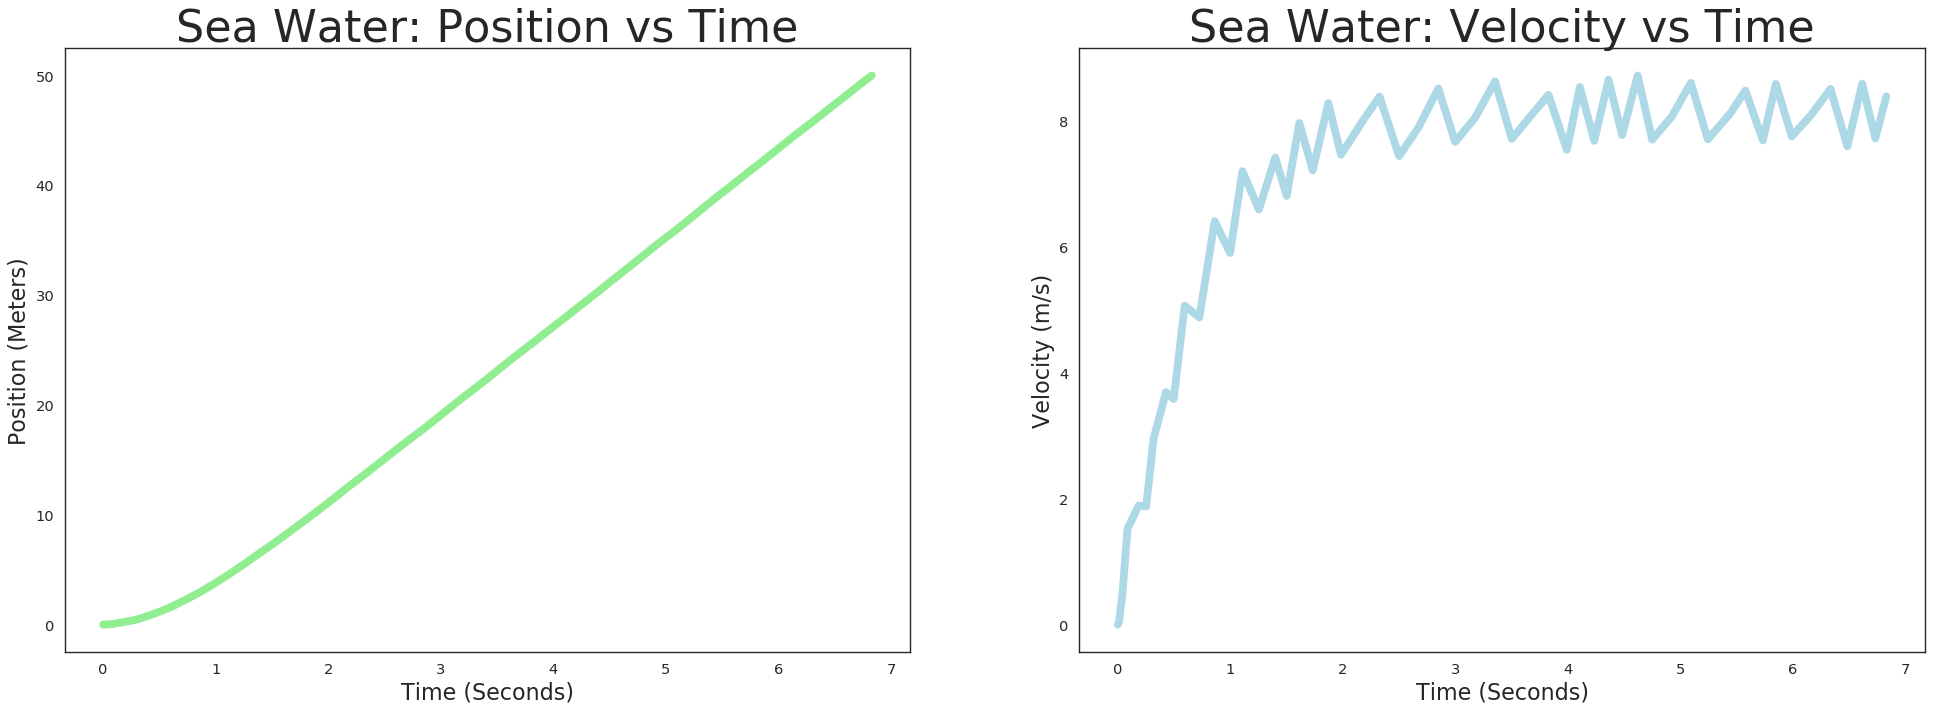

The total time it took the penguin to get to the end of the pool was 6.83 seconds.
The max speed of the penguin was 8.72 m/s or 31.38 kph.
The average speed of the penguin was 6.48 m/s or 23.32 kph.


In [66]:
params.rho = rho_sea_water
system = make_system(params)
results, details = run_ode_solver(system, slope_func, events=event_func, max_step = .2)
analyze_results(results, system, 'Sea Water')

The original question that inspired us to make this model: What happens if a penguin swims in syrup? (Ignoring the sugary effect on the penguin. I choose to believe that the penguin would just want to eat it right up).

Penguin mass:  5.8967 kilogram
Penguin flap rate:  4.0 times / second
Fluid density:  1370.0 kilogram / meter ** 3


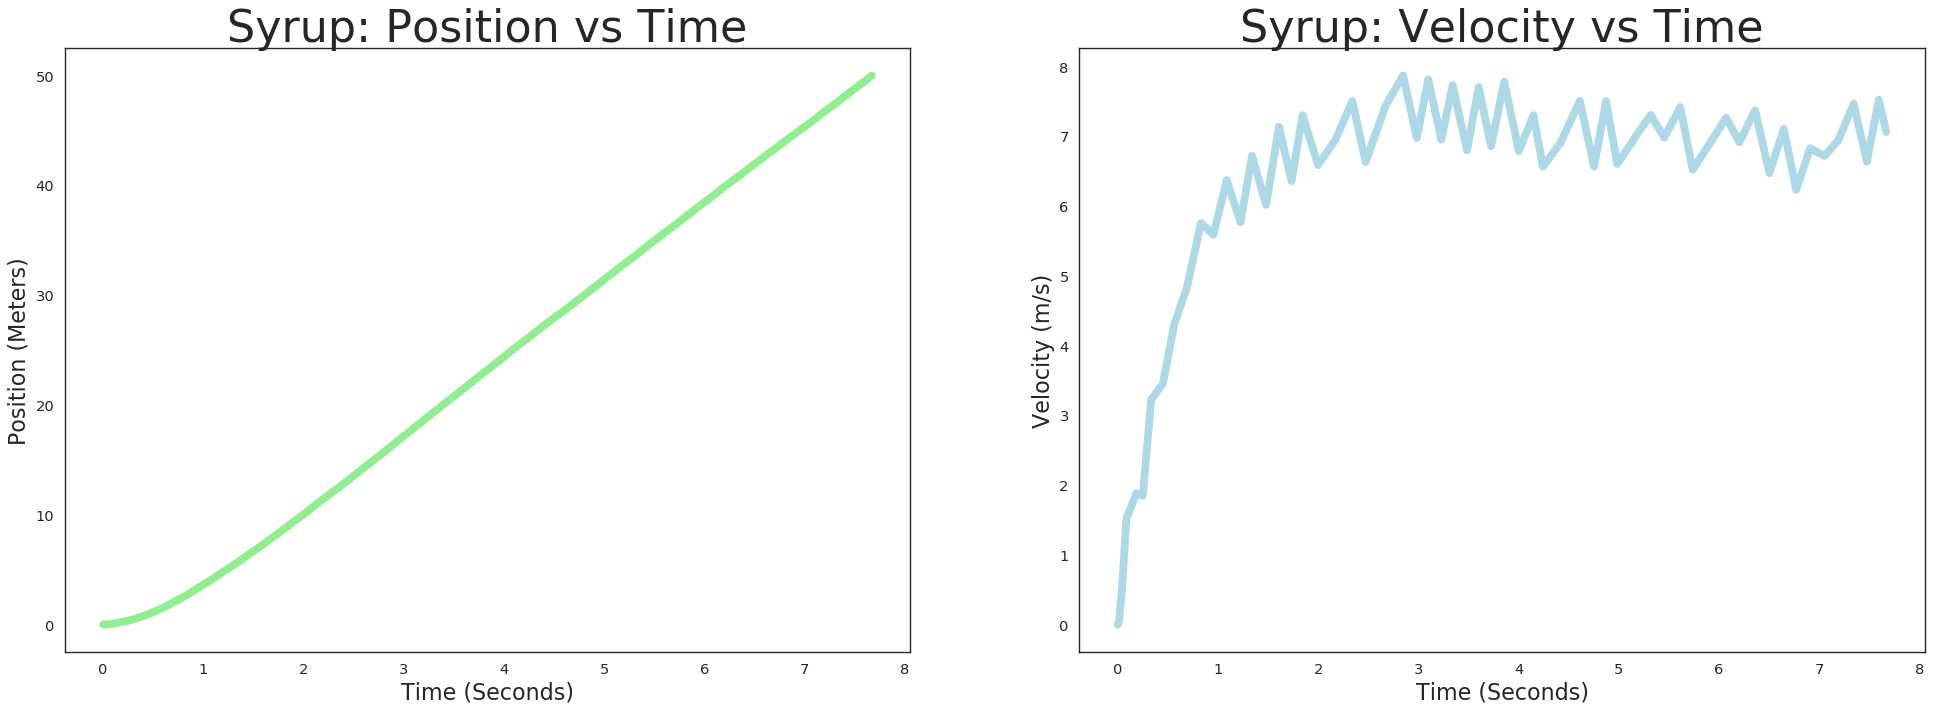

The total time it took the penguin to get to the end of the pool was 7.67 seconds.
The max speed of the penguin was 7.87 m/s or 28.34 kph.
The average speed of the penguin was 5.95 m/s or 21.41 kph.


In [63]:
params.rho = rho_syrup
system = make_system(params)
results, details = run_ode_solver(system, slope_func, events=event_func, max_step = .2)
analyze_results(results, system, 'Syrup')

Penguin mass:  5.8967 kilogram
Penguin flap rate:  4.0 times / second
Fluid density:  800.0 kilogram / meter ** 3


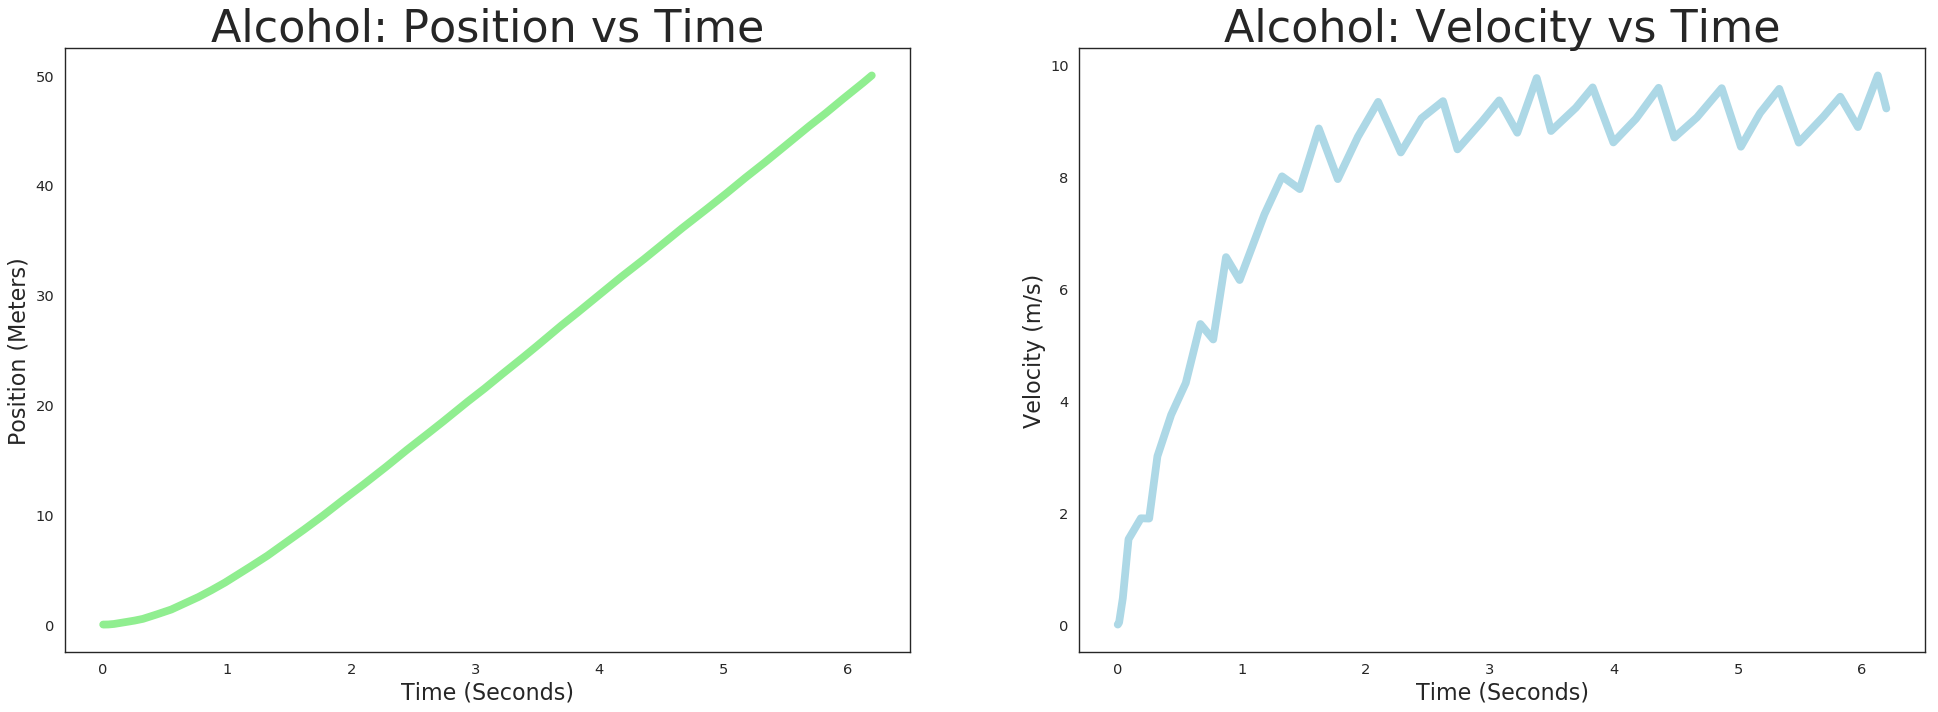

The total time it took the penguin to get to the end of the pool was 6.2 seconds.
The max speed of the penguin was 9.8 m/s or 35.29 kph.
The average speed of the penguin was 6.97 m/s or 25.09 kph.


In [64]:
params.rho = rho_propyl_alcohol
system = make_system(params)
results, details = run_ode_solver(system, slope_func, events=event_func, max_step =.2)
analyze_results(results, system, 'Alcohol')

# Interpretation